In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [ ]:
len(os.listdir('/content/final_grape_data/image'))

827

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x



# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)


In [ ]:
images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(128, 128))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(128, 128), grayscale=True)

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

In [ ]:
retVal = unet.fit(images_train, masks_train, validation_data=(images_test, masks_test), batch_size=16, epochs=20, verbose=1)

Epoch 1/20
42/42 [==============================] - 15s 99ms/step - loss: 0.2689 - accuracy: 0.9266 - val_loss: 5.2973 - val_accuracy: 0.1877
Epoch 2/20
42/42 [==============================] - 3s 71ms/step - loss: 0.1494 - accuracy: 0.9576 - val_loss: 0.5630 - val_accuracy: 0.7994
Epoch 3/20
42/42 [==============================] - 3s 71ms/step - loss: 0.1074 - accuracy: 0.9610 - val_loss: 0.2190 - val_accuracy: 0.9347
Epoch 4/20
42/42 [==============================] - 3s 75ms/step - loss: 0.0813 - accuracy: 0.9630 - val_loss: 0.1152 - val_accuracy: 0.9626
Epoch 5/20
42/42 [==============================] - 3s 78ms/step - loss: 0.0671 - accuracy: 0.9632 - val_loss: 0.0867 - val_accuracy: 0.9641
Epoch 6/20
42/42 [==============================] - 3s 76ms/step - loss: 0.0561 - accuracy: 0.9638 - val_loss: 0.0604 - val_accuracy: 0.9670
Epoch 7/20
42/42 [==============================] - 3s 76ms/step - loss: 0.0480 - accuracy: 0.9646 - val_loss: 0.0494 - val_accuracy: 0.9671
Epoch 8/20
4

In [ ]:
results = unet.predict(images_test)
pred_mask = np.squeeze(np.where(results > 0.5, 1, 0), axis=-1)

6/6 [==============================] - 0s 33ms/step


In [ ]:
loss, acc = unet.evaluate(images_test, masks_test)
loss, acc

6/6 [==============================] - 0s 27ms/step - loss: 0.0194 - accuracy: 0.9698


(0.019425783306360245, 0.9697813391685486)

In [ ]:
unet.save('unet1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


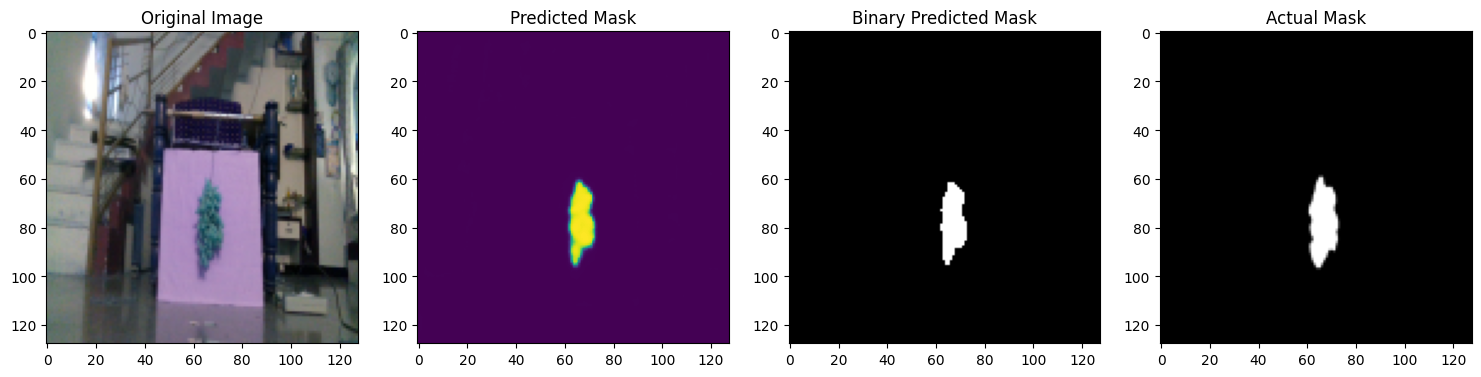

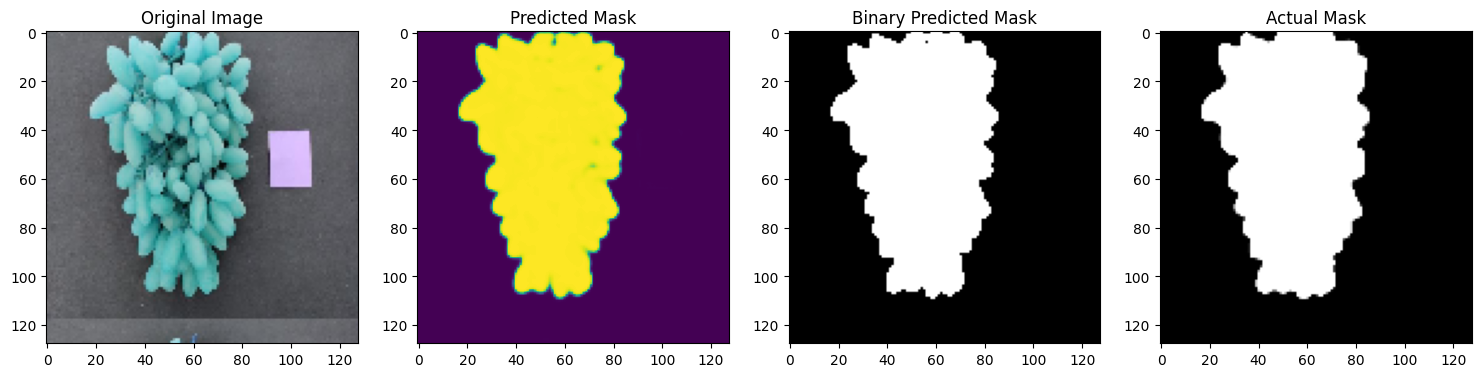

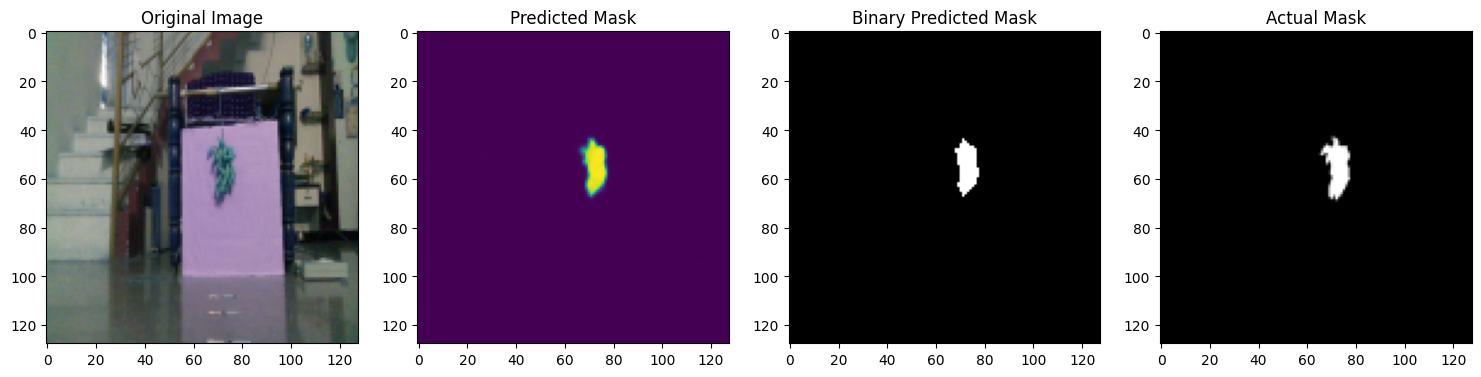

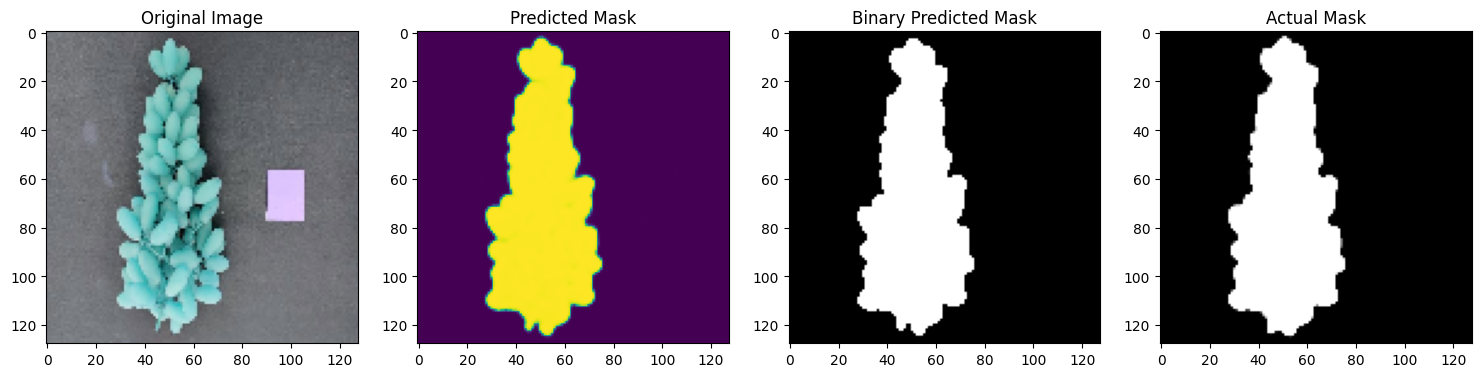

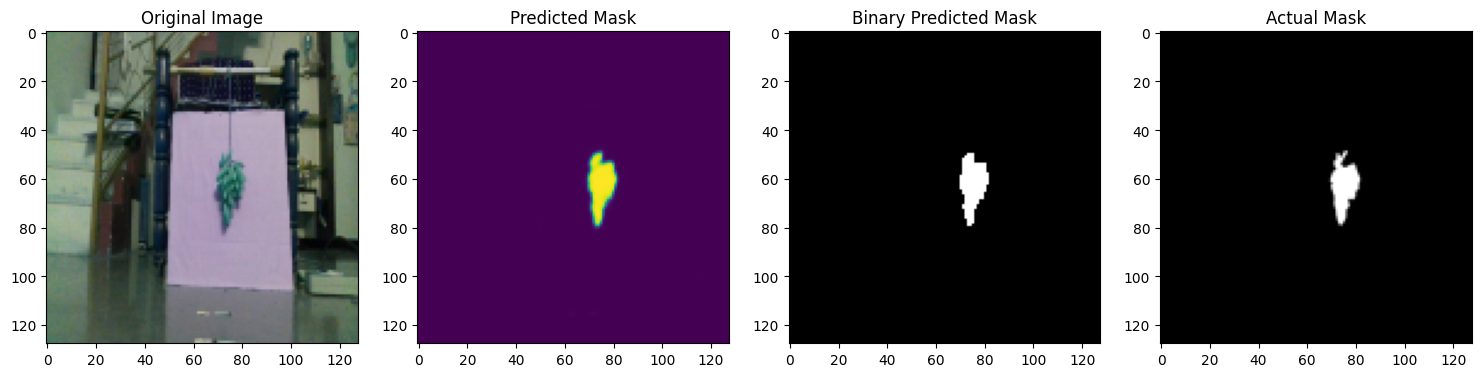

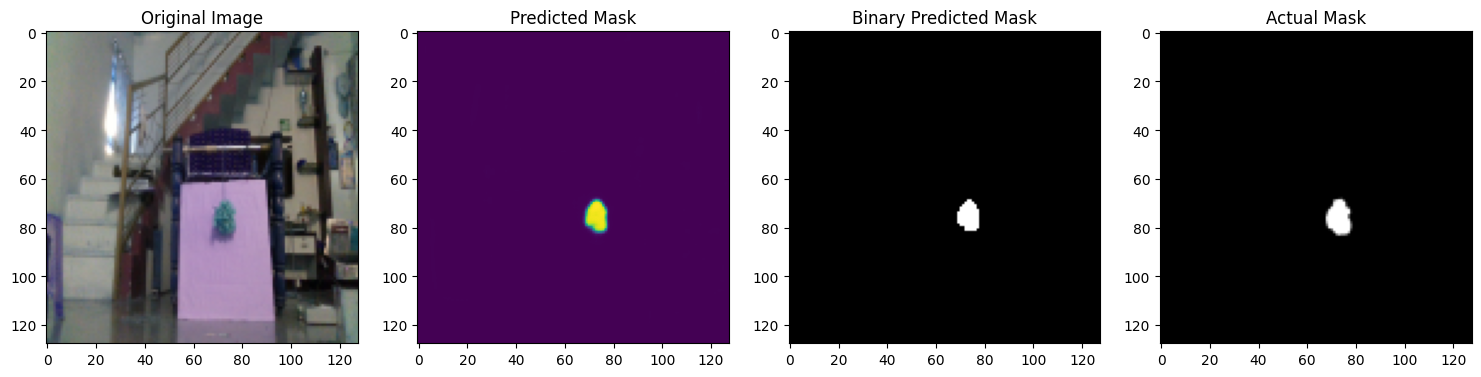

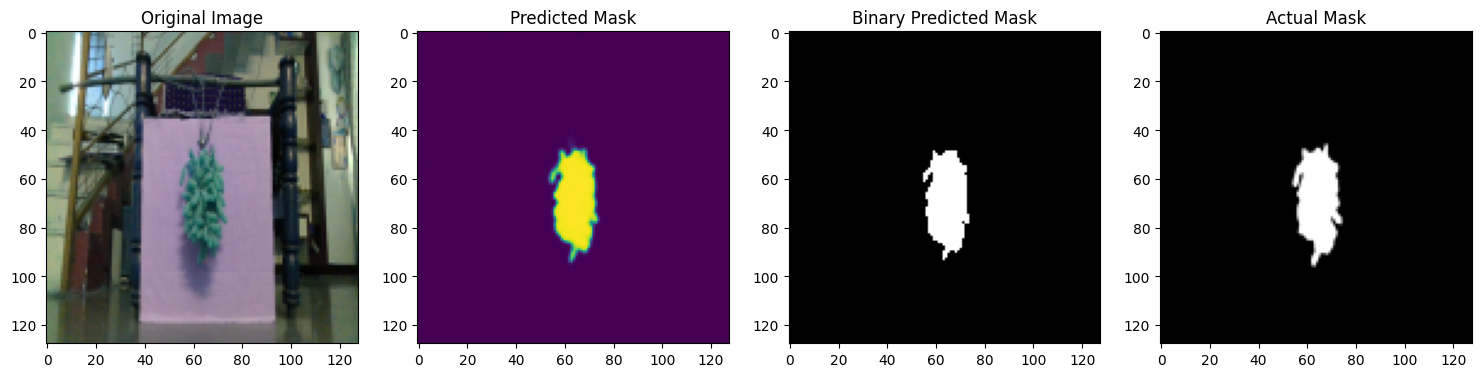

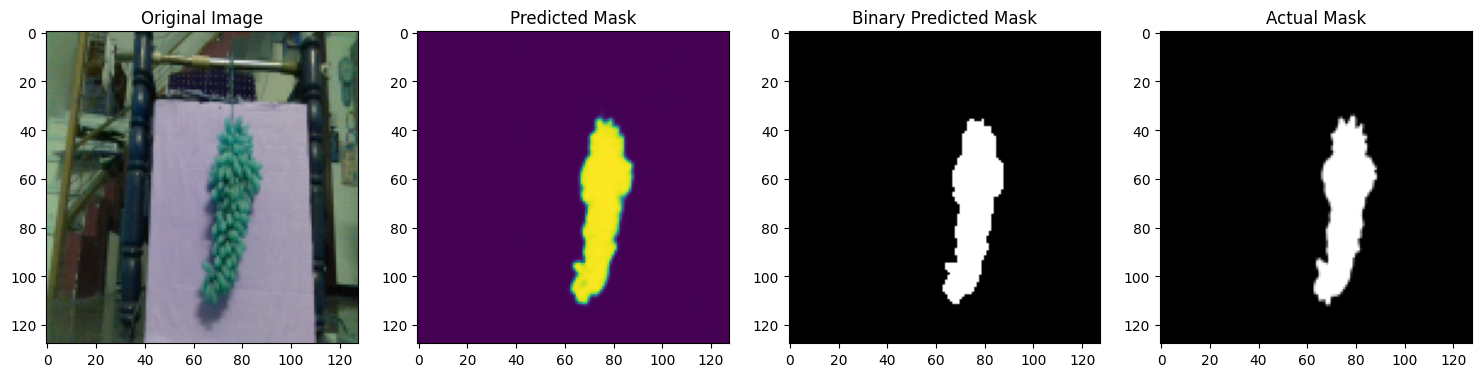

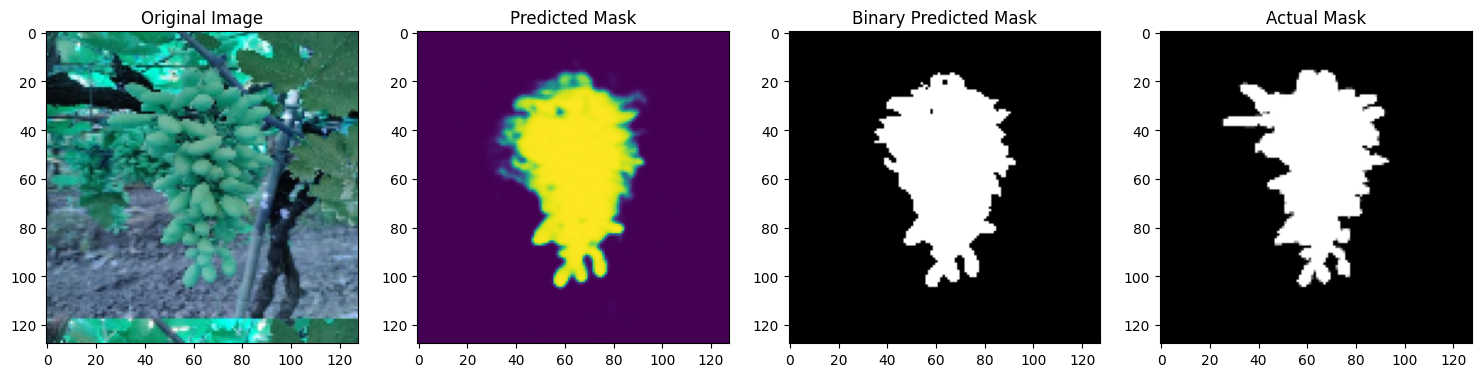

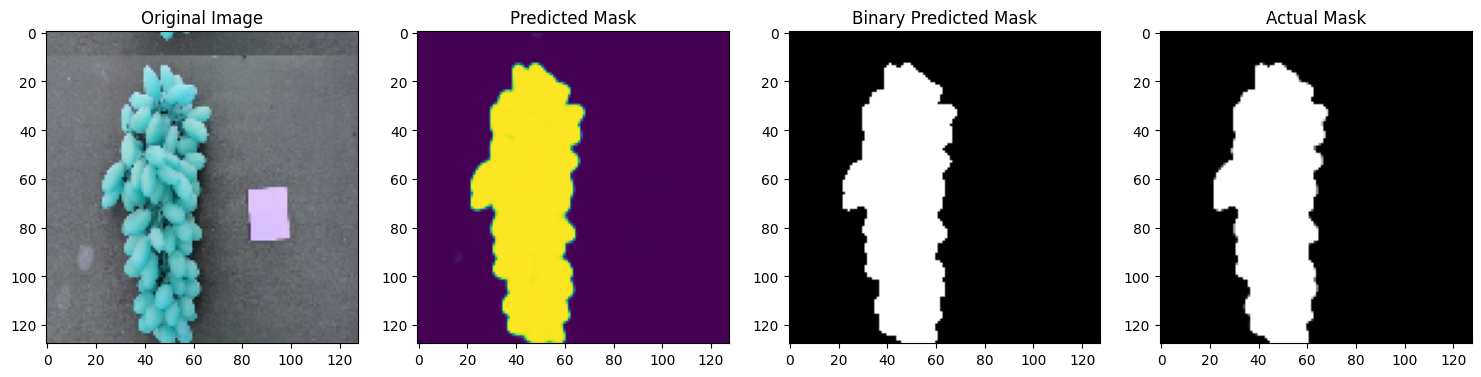

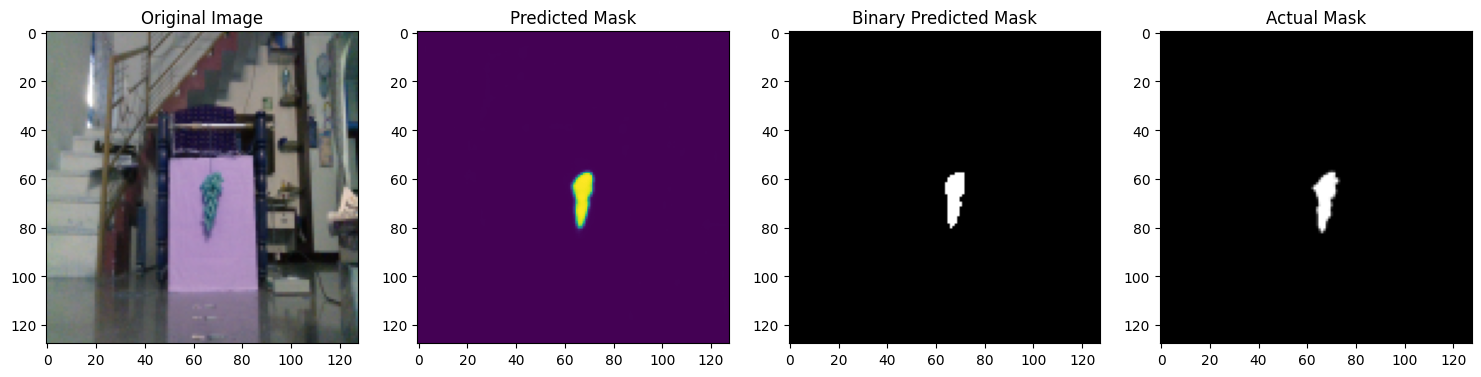

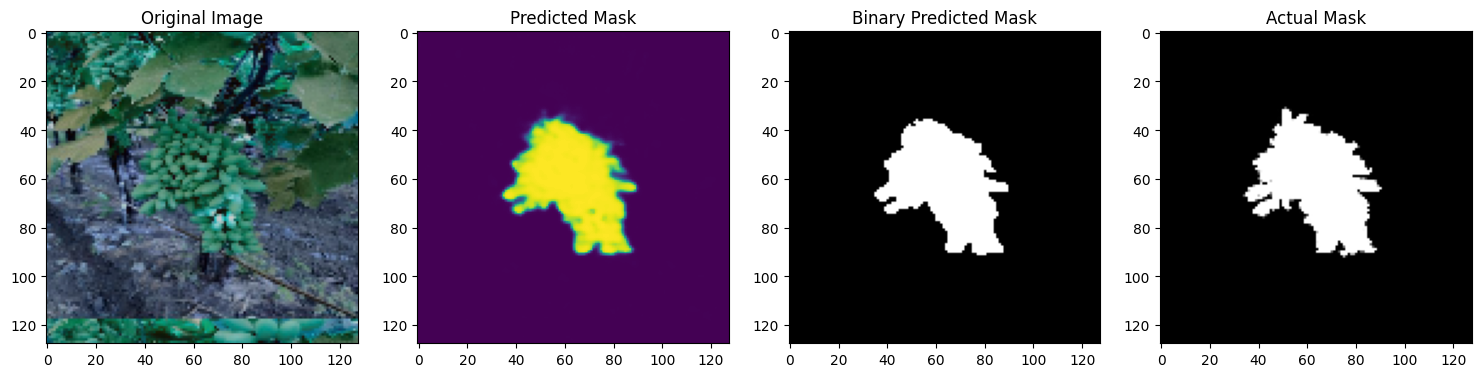

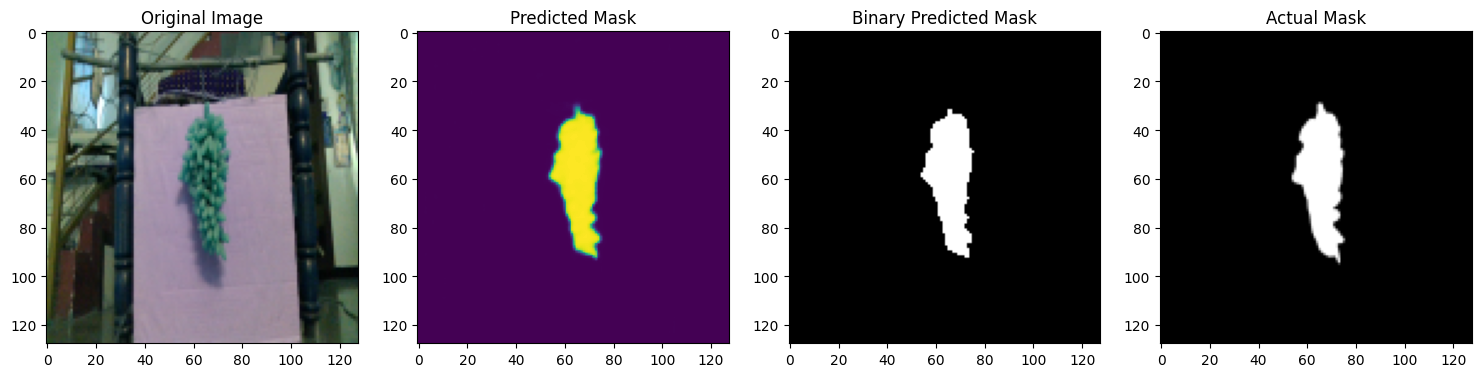

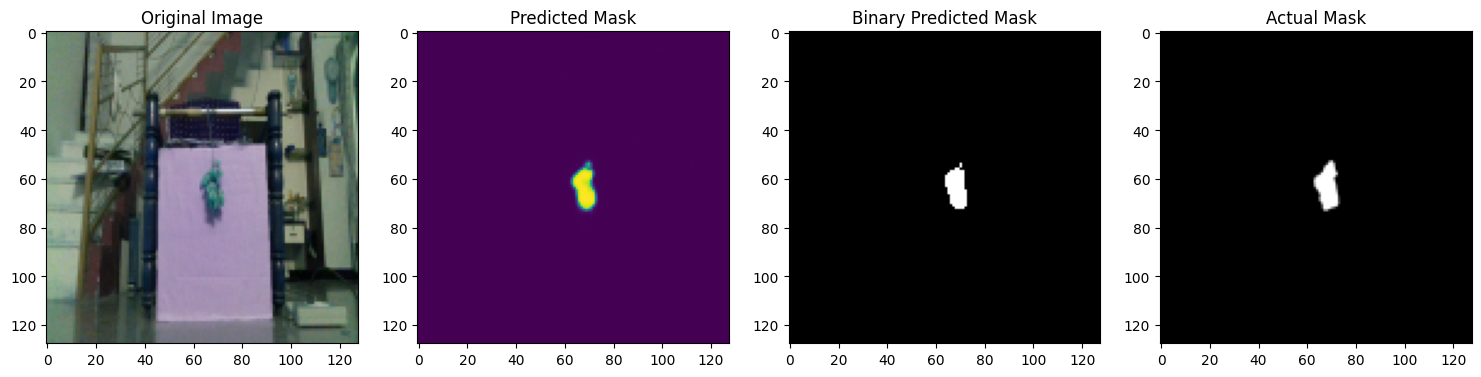

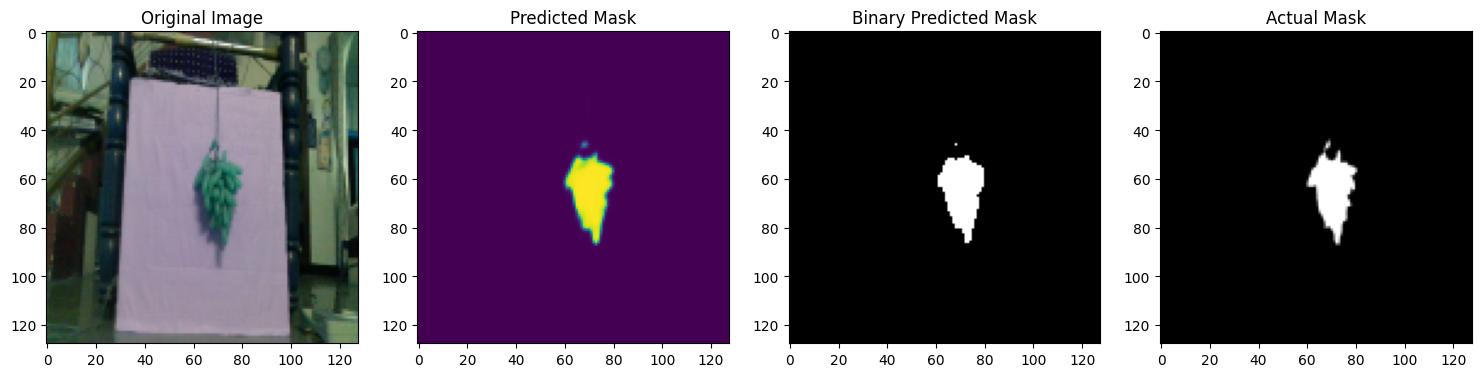

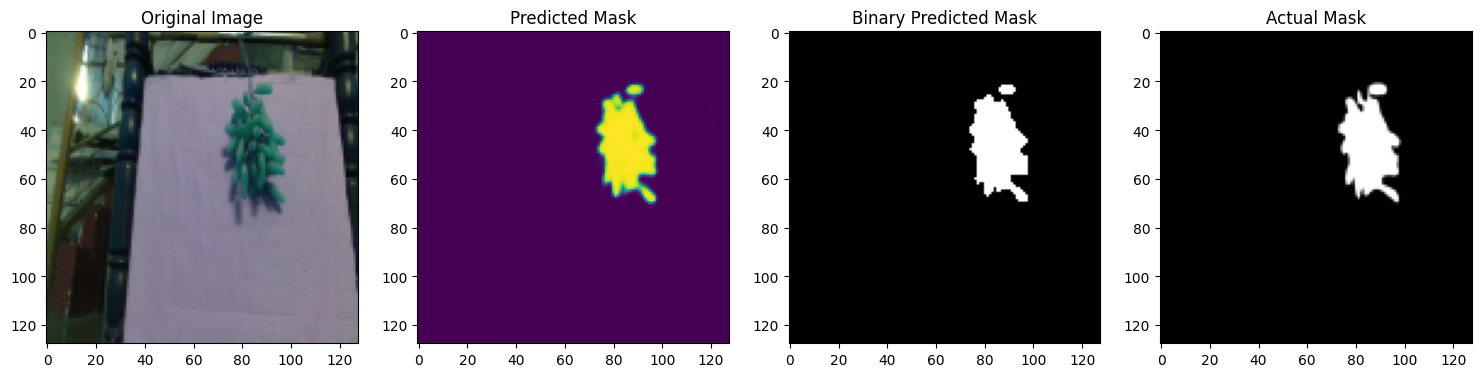

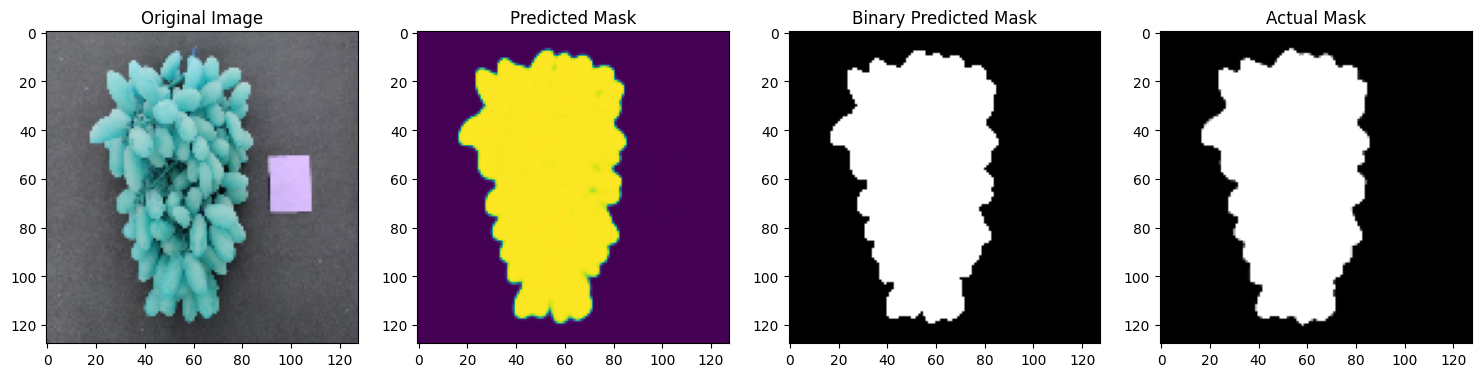

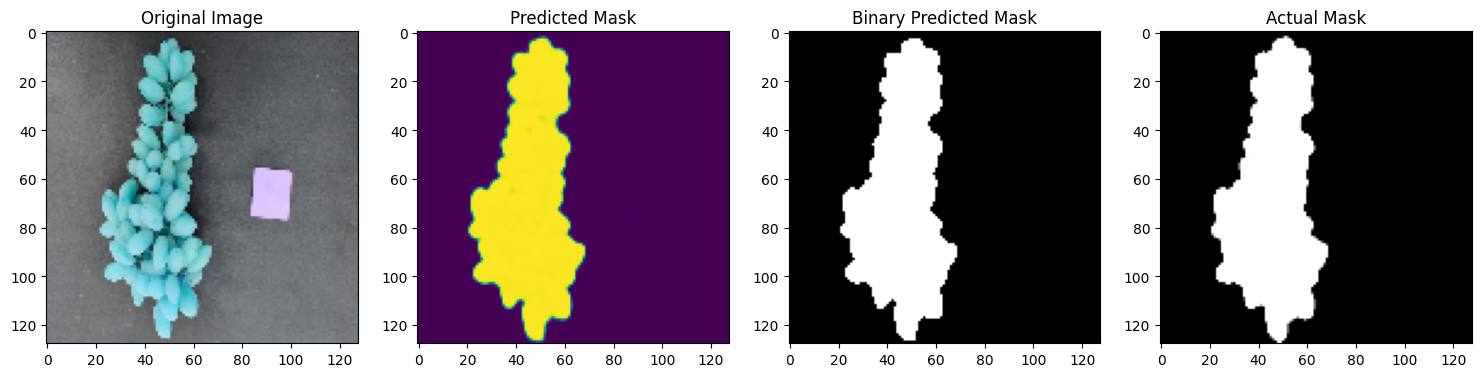

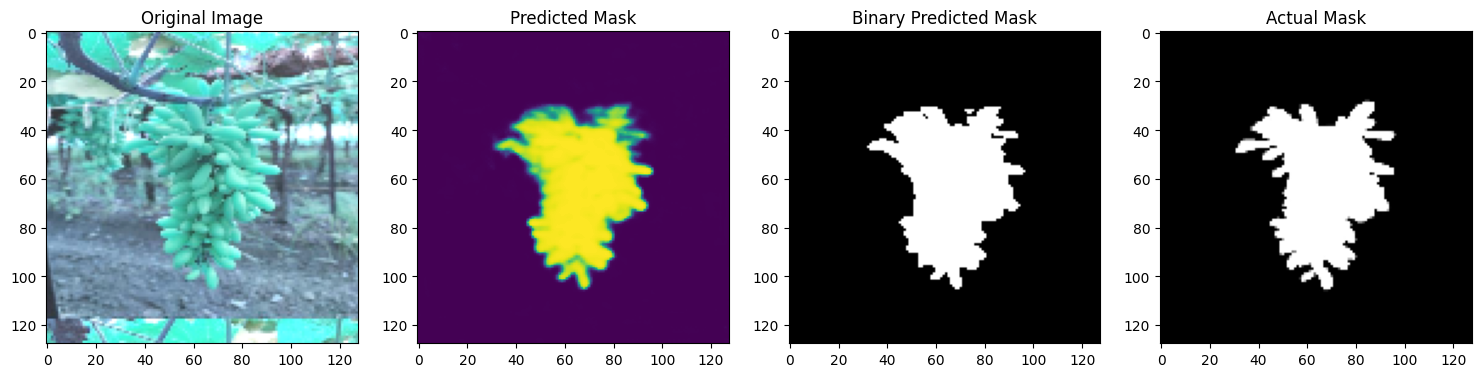

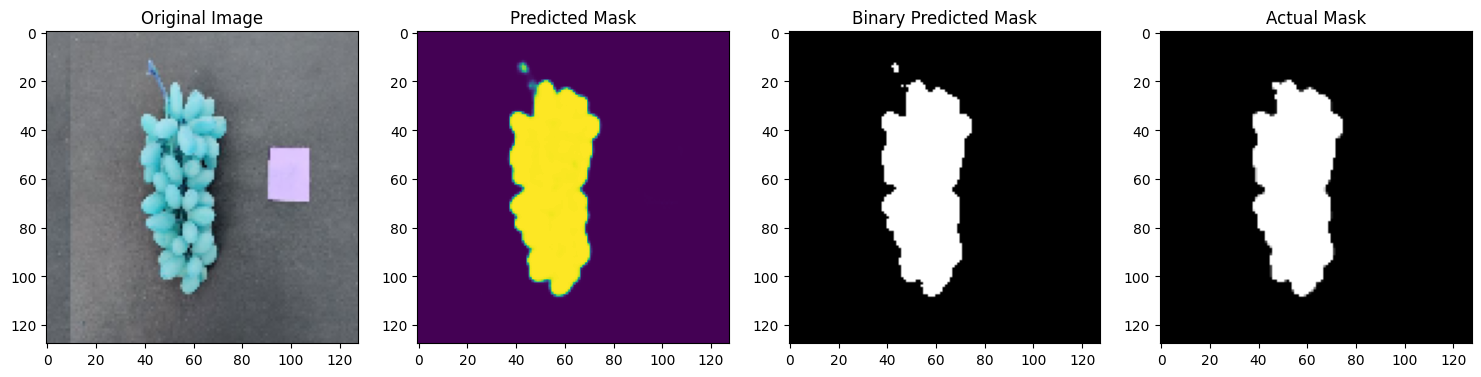

In [ ]:
for i in range(20):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

IoU: 0.8777471527380519
Dice Coefficient: 0.9731094743065983


In [ ]:
def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

Dice Loss: 0.026890525693401668
Focal Loss: 0.0233750038233351
